# Imort libraries

In [285]:
!brew install libomp

==> Downloading https://ghcr.io/v2/homebrew/core/libomp/manifests/12.0.0
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/libomp/blobs/sha256:fe1e5c0fa8f
==> Downloading from https://pkg-containers.githubusercontent.com/ghcr1/blobs/sh
######################################################################## 100.0%
==> Pouring libomp--12.0.0.big_sur.bottle.tar.gz
🍺  /usr/local/Cellar/libomp/12.0.0: 9 files, 1.5MB


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import keras
import tensorflow
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv1D, Input
from tensorflow.python.keras import regularizers
from keras.models import Model
import lightgbm as lgbm

# Import data & label data

In [46]:
#Import data and label data
frauds = pd.read_csv('data/frauds.csv')
nonfrauds = pd.read_csv('data/nonfrauds.csv')

frauds['user_transaction_time'] = pd.to_datetime(frauds['user_transaction_time'])
frauds['date'] = frauds['user_transaction_time'].dt.date

nonfrauds['user_transaction_time'] = pd.to_datetime(nonfrauds['user_transaction_time'])
nonfrauds['date'] = nonfrauds['user_transaction_time'].dt.date

frauds['is_fraud'] = 1
nonfrauds['is_fraud'] = 0

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [47]:
# Sampling for each day by taking 1% of good transactions and 100% of frauds

frauds_date = sorted(list(set(frauds['date'])))
nonfraud = pd.DataFrame()

for date in frauds_date:
    dftemp = nonfrauds.loc[nonfrauds['date'] == date]
    dftemp = dftemp.sample(frac = 0.02, random_state = 0)
    nonfraud = nonfraud.append(dftemp)

df = frauds.append(nonfraud)

In [48]:
df

,key,user_transaction_time,channel,transaction_risk_score,processing_type,cc_amount,ledger_balance,cc_acceptor_state,acceptor_state,cc_acceptor_country,cardholder_presence,card_presence,partial_approval_capable,pin_present,date,is_fraud
0,9d851f1b-00b3-4b02-9494-beda8866d6f7,2020-12-29 16:13:49+00:00,ECOMMERCE,82.0,MANUAL,14.99,134.91,NaN,NaN,HK,0.0,0.0,0.0,False,2020-12-29,1
1,dc13ebc6-a527-46d0-b424-6642d47c8a11,2020-12-29 16:13:32+00:00,ECOMMERCE,82.0,MANUAL,14.99,359.76,NaN,NaN,HK,0.0,0.0,0.0,False,2020-12-29,1
2,5e8f4d8f-a720-4a3d-ac55-f8953db3b527,2020-12-29 16:13:13+00:00,ECOMMERCE,82.0,MANUAL,14.99,419.72,NaN,NaN,HK,0.0,0.0,0.0,False,2020-12-29,1
3,74e6ff6d-f341-4300-8cac-30ab9e5ed5cf,2020-12-29 16:12:56+00:00,ECOMMERCE,82.0,MANUAL,14.99,149.90,NaN,NaN,HK,0.0,0.0,0.0,False,2020-12-29,1
4,c63d2508-f935-4092-bde1-434e1acbd0ef,2020-12-29 16:12:38+00:00,ECOMMERCE,82.0,MANUAL,14.99,164.89,NaN,NaN,HK,0.0,0.0,0.0,False,2020-12-29,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1674704,358ab4c9-ddd8-4522-a3cd-fe4879241c79,2020-12-29 22:37:51+00:00,ECOMMERCE,9.0,MANUAL,13.23,10482.07,FL,12,US,0.0,0.0,0.0,False,2020-12-29,0
1191861,c6676b24-5a23-4179-b473-aca3b6a43afb,2020-12-29 23:45:48+00:00,ECOMMERCE,1.0,CARD_ON_FILE,15.94,502.73,CA,6,US,0.0,0.0,0.0,False,2020-12-29,0
1192100,f4451c3a-e8b6-4518-98c7-fa92524713e7,2020-12-29 13:12:18+00:00,ECOMMERCE,1.0,CARD_ON_FILE,19.60,1284.85,CA,6,US,0.0,0.0,0.0,False,2020-12-29,0
568068,df9290eb-2501-4e8f-8f72-5aced1075561,2020-12-29 07:19:46+00:00,ECOMMERCE,5.0,CARD_ON_FILE,14.80,4695.56,AR,5,US,0.0,0.0,0.0,False,2020-12-29,0


# Data Exploration

Percentage of non frauds: 4.989344365049518%


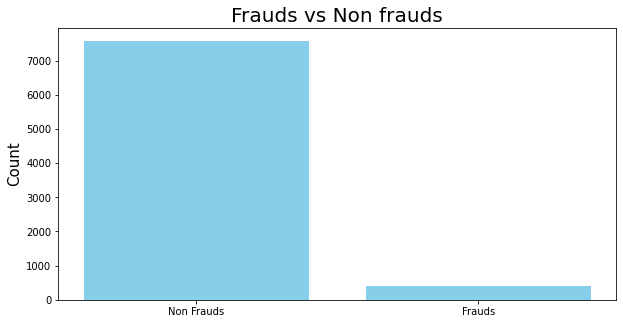

In [49]:
xaxis = ['Non Frauds', 'Frauds']
yaxis = list(df.is_fraud.value_counts())
plt.figure(figsize=(10,5))
plt.bar(xaxis,yaxis,color='skyblue')
plt.title("Frauds vs Non frauds", fontsize = 20)
plt.ylabel('Count', fontsize = 15)
print("Percentage of non frauds: " + str(df.is_fraud.value_counts(1)[1]*100) + "%")

Text(0, 0.5, 'Count of Non Frauds')

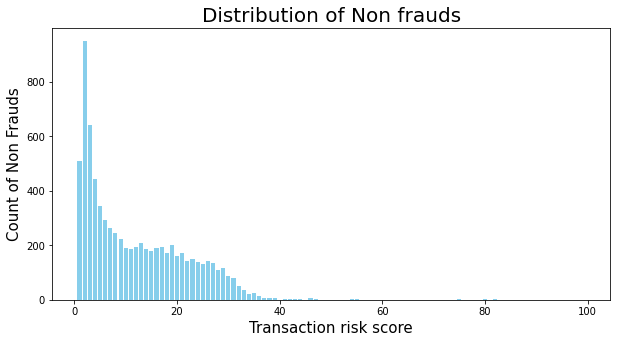

In [50]:
grpby_df = nonfraud.groupby(['transaction_risk_score']).count()
xaxis = list(grpby_df.index)
yaxis = list(grpby_df['key'])
plt.figure(figsize=(10,5))
plt.bar(xaxis,yaxis,color='skyblue')
plt.title('Distribution of Non frauds', fontsize=20)
plt.xlabel(r'Transaction risk score',fontsize=15)
plt.ylabel(r'Count of Non Frauds', fontsize=15)

Text(0, 0.5, 'Count of Frauds')

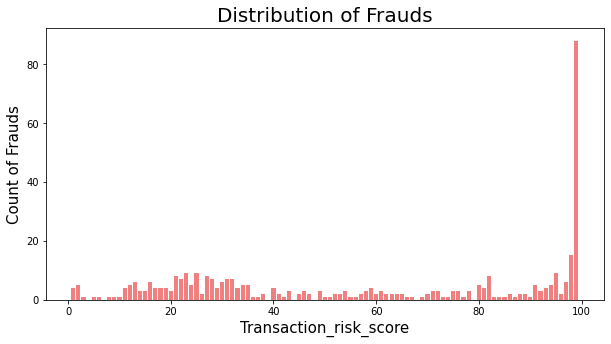

In [51]:
grpby_df = frauds.groupby(['transaction_risk_score']).count()
xaxis = list(grpby_df.index)
yaxis = list(grpby_df['key'])
plt.figure(figsize=(10,5))
plt.bar(xaxis,yaxis,color='lightcoral')
plt.title('Distribution of Frauds', fontsize=20)
plt.xlabel(r'Transaction_risk_score',fontsize=15)
plt.ylabel(r'Count of Frauds', fontsize=15)

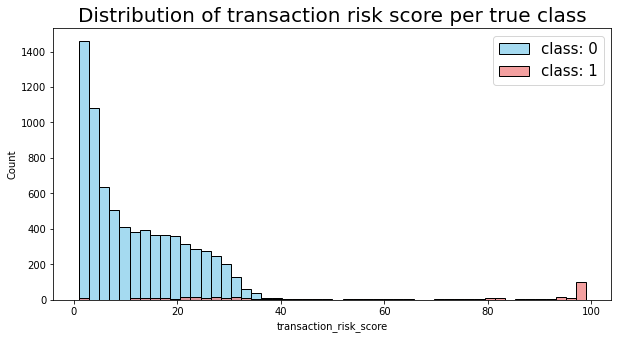

In [52]:
p0 = df[df['is_fraud'] == 0]['transaction_risk_score']
p1 = df[df['is_fraud'] == 1]['transaction_risk_score']

plt.figure(figsize=(10,5))
sns.histplot(p0, kde=False, bins=50, color='skyblue')
sns.histplot(p1, kde=False, bins=50, color='lightcoral')

plt.title("Distribution of transaction risk score per true class", fontsize=20)
plt.legend(["class: 0", "class: 1"], fontsize = 15)
plt.show()

# Preprocessing

## Fill in NA's

In [53]:
df['transaction_risk_score'] = df['transaction_risk_score'].fillna(df['transaction_risk_score'].mean())
df['channel'] = df['channel'].fillna('OTHER')
df['processing_type'] = df['processing_type'].fillna('UNKNOWN')
df[['cc_amount','ledger_balance','cardholder_presence','card_presence',
    'partial_approval_capable']] = df[['cc_amount','ledger_balance','cardholder_presence','card_presence',
                                       'partial_approval_capable']].fillna(0)
df['cc_acceptor_state'] = df['cc_acceptor_state'].fillna('UNKNOWN')

## Encode categorical variables and create new data frame from those

In [54]:
cat_cols = ['channel','processing_type','cc_acceptor_state','cc_acceptor_country']
for c in cat_cols:
    df[c] = df[c].astype('category').cat.codes

In [68]:
df = pd.read_csv('data/input.csv')

In [69]:
df2 = df[['transaction_risk_score','cc_amount','ledger_balance','cardholder_presence','card_presence',
          'partial_approval_capable','channel','processing_type','date','cc_acceptor_state','cc_acceptor_country','is_fraud']]
df2 = df2.sort_values(by='date')
df2 = df2.drop("date",axis=1)

In [70]:
df2

,transaction_risk_score,cc_amount,ledger_balance,cardholder_presence,card_presence,partial_approval_capable,channel,processing_type,cc_acceptor_state,cc_acceptor_country,is_fraud
0,54.0,52.79,0.00,0,0,0,2,5,52,32,1
24,31.0,14.70,1333.74,0,0,0,0,4,10,33,0
25,28.0,23.95,3889.14,0,0,0,0,4,10,33,0
26,35.0,20.15,3323.75,0,0,0,0,4,57,33,0
27,18.0,26.08,1224.32,1,1,1,2,3,51,33,0
...,...,...,...,...,...,...,...,...,...,...,...
35651,11.0,1000.00,6441.18,0,0,0,1,4,28,33,0
35650,2.0,26.43,916.11,0,0,0,0,0,26,33,0
35649,1.0,21.78,18107.36,0,0,0,0,4,15,33,0
35657,16.0,21.35,163.44,0,0,0,0,4,52,6,0


# Train-test split and standard scaling

In [110]:
training_set, test_set = np.split(df2, [int(.6 *len(df2))])

X_train = training_set.drop("is_fraud",axis=1)
y_train = training_set[['is_fraud']].values.flatten()

X_test = test_set.drop("is_fraud",axis=1)
y_test = test_set[['is_fraud']].values.flatten()

scalar = StandardScaler()
x_train_scale = scalar.fit_transform(X_train)
x_test_scale = scalar.transform(X_test)

# Random Forest Classifier

In [111]:
%%time

clf = RandomForestClassifier(n_estimators=500, max_depth=15, random_state=0)
clf.fit(x_train_scale,y_train)
pred = clf.predict(x_test_scale)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13548
           1       1.00      0.97      0.98       735

    accuracy                           1.00     14283
   macro avg       1.00      0.98      0.99     14283
weighted avg       1.00      1.00      1.00     14283

CPU times: user 7.29 s, sys: 92.7 ms, total: 7.38 s
Wall time: 7.94 s


# LightGBM

In [112]:
%%time

lgbm_clf = lgbm.LGBMClassifier(
    objective="binary",
    n_estimators=10000,
)
eval_set = [(x_test_scale,y_test)]

lgbm_clf.fit(
    x_train_scale,
    y_train,
    eval_set=eval_set,
    early_stopping_rounds=100,
    eval_metric="binary_logloss",
    verbose=-1
)

preds = lgbm_clf.predict(x_test_scale)
preds
print(classification_report(y_test,preds))

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13548
           1       0.98      0.98      0.98       735

    accuracy                           1.00     14283
   macro avg       0.99      0.99      0.99     14283
weighted avg       1.00      1.00      1.00     14283

CPU times: user 3.77 s, sys: 300 ms, total: 4.07 s
Wall time: 2.59 s


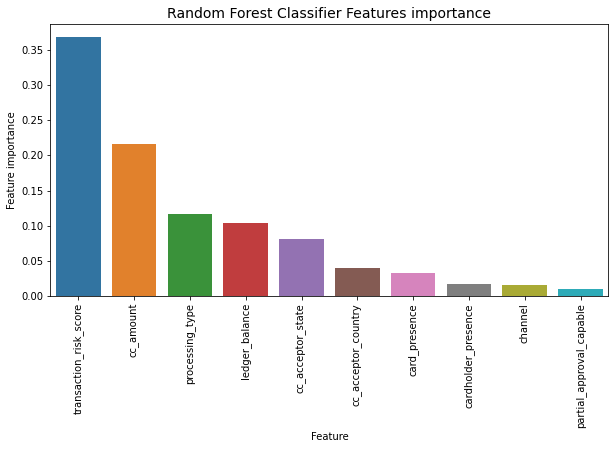

In [62]:
predictors = ['transaction_risk_score','cc_amount','ledger_balance','cardholder_presence','card_presence',
          'partial_approval_capable','channel','processing_type','cc_acceptor_state','cc_acceptor_country']
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (10,5))
plt.title('Random Forest Classifier Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

# ANN

In [63]:
from tensorflow.keras.optimizers import SGD

metrics = [
    'accuracy',
    keras.metrics.Precision(),
    keras.metrics.Recall()
]

epochs=100
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
input_dim = x_train_scale.shape[1]

sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

def NN():
    model = keras.Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = metrics)
    
    return model

In [64]:
from keras.callbacks import EarlyStopping
model = NN()
lr_model_history = model.fit(x_train_scale, y_train, validation_data = (x_test_scale, y_test), 
                             batch_size = 32, epochs = epochs, verbose = 1,
                             callbacks=EarlyStopping(monitor='val_loss',patience=10))

Epoch 1/100
200/200 [==============================] - 2s 4ms/step - loss: 0.1125 - accuracy: 0.9672 - precision_1: 0.7426 - recall_1: 0.3673 - val_loss: 0.0547 - val_accuracy: 0.9843 - val_precision_1: 0.9537 - val_recall_1: 0.8374
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0798 - accuracy: 0.9735 - precision_1: 0.7760 - recall_1: 0.5418 - val_loss: 0.0490 - val_accuracy: 0.9818 - val_precision_1: 0.9700 - val_recall_1: 0.7886
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0779 - accuracy: 0.9759 - precision_1: 0.8343 - recall_1: 0.5491 - val_loss: 0.0468 - val_accuracy: 0.9850 - val_precision_1: 0.9304 - val_recall_1: 0.8699
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0763 - accuracy: 0.9771 - precision_1: 0.8241 - recall_1: 0.5964 - val_loss: 0.0477 - val_accuracy: 0.9887 - val_precision_1: 0.9565 - val_recall_1: 0.8943
Epoch 5/100
200/200 [==============================] - 0s 2ms/step -

In [65]:
print("new")
print('accuracy: ' + str(model.evaluate(x_test_scale,y_test, verbose=0)[1]))
print('precision: ' + str(model.evaluate(x_test_scale,y_test, verbose=0)[2]))
print('recall: ' + str(model.evaluate(x_test_scale,y_test, verbose=0)[3]))

new
accuracy: 0.9899749159812927
precision: 0.9652174115180969
recall: 0.9024389982223511


In [326]:
print('accuracy: ' + str(model.evaluate(x_test_scale,y_test, verbose=0)[1]))
print('precision: ' + str(model.evaluate(x_test_scale,y_test, verbose=0)[2]))
print('recall: ' + str(model.evaluate(x_test_scale,y_test, verbose=0)[3]))

accuracy: 0.9959642291069031
precision: 0.9638554453849792
recall: 0.6722689270973206


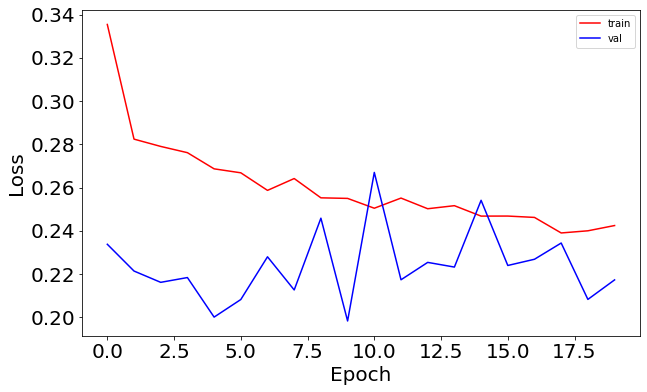

In [66]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

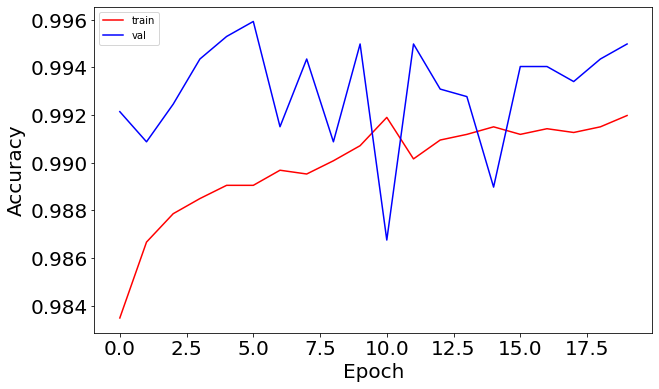

In [67]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)